## Imports

In [ ]:
!pip -q install optbinning

In [ ]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

import optbinning

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Data Loading

In [ ]:
train_df = pd.read_csv("/kaggle/input/analytics-olympiad-2023/train.csv")
test_df = pd.read_csv("/kaggle/input/analytics-olympiad-2023/test.csv")
ss_df = pd.read_csv("/kaggle/input/analytics-olympiad-2023/submission.csv")

In [ ]:
train_df.shape, test_df.shape, ss_df.shape

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
ss_df.head()

## Data Processing

In [ ]:
train_df.isna().sum().sort_values(ascending=False).head(30)

In [ ]:
test_df.isna().sum().sort_values(ascending=False).head(30)

In [ ]:
train_df.describe().round(2)

In [ ]:
train_df['customer_id'].value_counts()

In [ ]:
test_df['customer_id'].value_counts()

In [ ]:
train_customer_id_set = set(train_df['customer_id'].values.tolist())
test_customer_id_set = set(test_df['customer_id'].values.tolist())

venn2([train_customer_id_set, test_customer_id_set], ('Train', 'Test'))
plt.show()

In [ ]:
train_df[train_df['customer_id'] == 'bd3685fc-3999-46bd-9010-efa26e442c1b'].sort_values('record_number').head()

In [ ]:
credit_record_columns = [
    'record_number',
    'days_since_opened', 'days_since_confirmed', 'primary_term',
    'final_term', 'days_till_primary_close', 'days_till_final_close',
    'loans_credit_limit', 'loans_next_payment_summary',
    'loans_outstanding_balance', 'loans_max_overdue_amount',
    'loans_credit_cost_rate'
]

loan_overdue_columns = [
    'loans_within_5_days',
    'loans_within_5_to_30_days', 'loans_within_30_to_60_days',
    'loans_within_60_to_90_days', 'loans_over_90_days',
    
    'is_zero_loans_within_5_days', 'is_zero_loans_within_5_to_30_days',
    'is_zero_loans_within_30_to_60_days',
    'is_zero_loans_within_60_to_90_days', 'is_zero_loans_over_90_days',
]

credit_util_limit_columns = [
    'utilization', 'over_limit_count', 'max_over_limit_count',
    'is_zero_utilization', 'is_zero_over_limit_count',
    'is_zero_max_over_limit_count'
]

encoded_features_columns = [
    'encoded_payment_0',
    'encoded_payment_1', 'encoded_payment_2', 'encoded_payment_3',
    'encoded_payment_4', 'encoded_payment_5', 'encoded_payment_6',
    'encoded_payment_7', 'encoded_payment_8', 'encoded_payment_9',
    'encoded_payment_10', 'encoded_payment_11', 'encoded_payment_12',
    'encoded_payment_13', 'encoded_payment_14', 'encoded_payment_15',
    'encoded_payment_16', 'encoded_payment_17', 'encoded_payment_18',
    'encoded_payment_19', 'encoded_payment_20', 'encoded_payment_21',
    'encoded_payment_22', 'encoded_payment_23', 'encoded_payment_24',
    'encoded_loans_account_holder_type', 'encoded_loans_credit_status',
    'encoded_loans_credit_type', 'encoded_loans_account_currency',
]

target_columns = [
    'primary_close_flag', 'final_close_flag'
]

In [ ]:
train_df[credit_record_columns].describe().round(2)

In [ ]:
train_df[loan_overdue_columns].describe().round(2)

In [ ]:
train_df[loan_overdue_columns].head()

In [ ]:
loan_cat_columns = ['is_zero_loans_within_5_days', 'is_zero_loans_within_5_to_30_days', 'is_zero_loans_within_30_to_60_days',
    'is_zero_loans_within_60_to_90_days', 'is_zero_loans_over_90_days']

train_df[loan_cat_columns] = train_df[loan_cat_columns].replace({'Yes' : 1, 'No' : 0})
test_df[loan_cat_columns] = test_df[loan_cat_columns].replace({'Yes' : 1, 'No' : 0})

In [ ]:
train_df[loan_overdue_columns].describe().round(2)

In [ ]:
credit_cat_columns = ['is_zero_utilization', 'is_zero_over_limit_count', 'is_zero_max_over_limit_count']

train_df[credit_cat_columns] = train_df[credit_cat_columns].replace({'Yes' : 1, 'No' : 0})
test_df[credit_cat_columns] = test_df[credit_cat_columns].replace({'Yes' : 1, 'No' : 0})

In [ ]:
train_df[credit_util_limit_columns].describe().round(2)

In [ ]:
train_df[encoded_features_columns].describe().round(2)

## EDA

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(data=train_df, x='primary_close_flag', ax=axes[0])
sns.countplot(data=train_df, x='final_close_flag', ax=axes[1])
plt.show()

In [ ]:
train_df['primary_close_flag'].value_counts(normalize=True).round(4) * 100

In [ ]:
train_df['final_close_flag'].value_counts(normalize=True).round(4) * 100

In [ ]:
train_df[target_columns].value_counts(normalize=True).reset_index().round(4)

In [ ]:
train_df[target_columns].corr()

In [ ]:
train_df.head()

In [ ]:
# check each customer id length

fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=train_df.groupby("customer_id")['customer_id'].count().values)
plt.title("train customer profile length")
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=test_df.groupby("customer_id")['customer_id'].count().values)
plt.title("test customer profile length")
plt.show()

In [ ]:
def plot_feature_distributions(data, feature_names):
    import math
    num_features = len(feature_names)
    num_columns = 3
    num_rows = math.ceil(num_features / num_columns)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5*num_rows))
    
    for i, feature in enumerate(feature_names):
        row_idx = i // num_columns
        col_idx = i % num_columns
        ax = axes[row_idx, col_idx]
        
        sns.countplot(data=data, x=feature, ax=ax)
        
        ax.set_title(f'Distribution of {feature}')
    
    # Remove empty subplots if there are fewer features than expected
    for i in range(num_features, num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_feature_distributions(train_df, feature_names=credit_record_columns)

In [ ]:
plot_feature_distributions(train_df, feature_names=loan_overdue_columns)

In [ ]:
plot_feature_distributions(train_df, feature_names=credit_util_limit_columns)

In [ ]:
plot_feature_distributions(train_df, feature_names=encoded_features_columns)

Weight of Evidence(WOE)
The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.

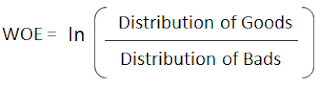

* Distribution of Goods - % of Good Customers in a particular group
* Distribution of Bads - % of Bad Customers in a particular group
* ln - Natural Log

### Steps of Calculating WOE

* For a continuous variable, split data into 10 parts (or lesser depending on the distribution).
* Calculate the number of events and non-events in each group (bin)
* Calculate the % of events and % of non-events in each group.
* Calculate WOE by taking natural log of division of % of non-events and % of events
* Information Value(IV)
* Information value is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance.

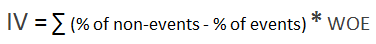

### If the IV statistic is:

* Less than 0.02, then the predictor is not useful for modeling (separating the Goods from the Bads)
* 0.02 to 0.1, then the predictor has only a weak relationship to the Goods/Bads odds ratio
* 0.1 to 0.3, then the predictor has a medium strength relationship to the Goods/Bads odds ratio
* 0.3 to 0.5, then the predictor has a strong relationship to the Goods/Bads odds ratio.
* 0.5, suspicious relationship (Check once)

Reference: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

## Information Value (IV)

* for selecting features we are calculating IV values for each feature
* thankfully optbinning will do for us :)

In [ ]:
target_col1 = 'primary_close_flag'
target_col2 = 'final_close_flag'
drop_cols = ['customer_id', 'firstname', 'lastname', target_col1, target_col2]
cat_cols = []
train_cols = [col for col in train_df.columns if col not in drop_cols]

In [ ]:
iv_score_dict = {}
for col in tqdm(train_cols):
    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df[target_col1])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df[target_col1])
    binning_table = optb.binning_table
    binning_table.build()
    iv_score_dict[col] = binning_table.iv

iv_score_df1 = pd.Series(iv_score_dict)
iv_score_df1.sort_values(ascending=False, inplace=True)

In [ ]:
# top 10 imp iv features
iv_score_df1.head(10)

In [ ]:
# iv score vs features
fig, ax = plt.subplots(figsize=(20,5))
iv_score_df1.reset_index(drop=True).plot()
plt.show()

In [ ]:
iv_score_dict = {}
for col in tqdm(train_cols):
    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df[target_col2])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df[target_col2])
    binning_table = optb.binning_table
    binning_table.build()
    iv_score_dict[col] = binning_table.iv

iv_score_df2 = pd.Series(iv_score_dict)
iv_score_df2.sort_values(ascending=False, inplace=True)

In [ ]:
# top 10 imp iv features
iv_score_df2.head(10)

In [ ]:
# iv score vs features
fig, ax = plt.subplots(figsize=(20,5))
iv_score_df2.reset_index(drop=True).plot()
plt.show()

## Weight of Evidence (WOE)
- i will try to explan woe values and woe plot for one feature

In [ ]:
train_df['days_till_primary_close'].hist()
plt.show()

In [ ]:
col = 'days_till_primary_close'
optb = optbinning.OptimalBinning(dtype='numerical', max_n_bins=10)
optb.fit(train_df[col], train_df[target_col1])
binning_table = optb.binning_table
display(binning_table.build())

* days_till_primary_close is a continuous feature, os we splited into 4 bins
* each bin have non-event and event counts and rates
* each bin have WOE and IV values
* for missing values it's created 5th bin

In [ ]:
display(binning_table.plot(metric="woe"))

In [ ]:
col = 'days_till_final_close'
optb = optbinning.OptimalBinning(dtype='numerical', max_n_bins=10)
optb.fit(train_df[col], train_df[target_col2])
binning_table = optb.binning_table
display(binning_table.build())

In [ ]:
display(binning_table.plot(metric="woe"))

In [ ]:
# WOE plots for top 10 features
top5_features = iv_score_df1[:5].index.values

for col in top5_features:
    print("-"*100)
    print("="*100)
    print("################ Feature Name : ", col)
    print("\n\n")

    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df[target_col1])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df[target_col1])

    binning_table = optb.binning_table
    display(binning_table.build())
    display(binning_table.plot(metric="woe"))

In [ ]:
# WOE plots for top 10 features
top5_features = iv_score_df2[:5].index.values

for col in top5_features:
    print("-"*100)
    print("="*100)
    print("################ Feature Name : ", col)
    print("\n\n")

    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df[target_col2])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df[target_col2])

    binning_table = optb.binning_table
    display(binning_table.build())
    display(binning_table.plot(metric="woe"))

### selecting features IV values > 0.02

In [ ]:
selected_features = iv_score_df1[iv_score_df1 > 0.02].index.values
cat_cols = [col for col in cat_cols if col in selected_features]
train_cols1 = [col for col in train_df.columns if col in selected_features]

train_cols1.__len__()

In [ ]:
selected_features = iv_score_df2[iv_score_df2 > 0.02].index.values
cat_cols = [col for col in cat_cols if col in selected_features]
train_cols2 = [col for col in train_df.columns if col in selected_features]

train_cols2.__len__()

In [ ]:
top_cols = [col for col in selected_features[:20] if col in train_cols]
corr_df = train_df[top_cols].corr()
plt.figure(figsize=(25, 9))
sns.heatmap(corr_df,annot=True ,cmap=sns.color_palette("BrBG",2));
plt.show()

## Modeling

In [ ]:
# train valid split
train_data1, valid_data1 = model_selection.train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True, stratify=train_df[target_col1])
train_data2, valid_data2 = model_selection.train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True, stratify=train_df[target_col2])

train_data1.shape, valid_data1.shape, train_data2.shape, valid_data2.shape

In [ ]:
X_train1 = train_data1[train_cols1].copy()
y_train1 = train_data1[target_col1].copy()

X_valid1 = valid_data1[train_cols1].copy()
y_valid1 = valid_data1[target_col1].copy()

X_train2 = train_data2[train_cols2].copy()
y_train2 = train_data2[target_col2].copy()

X_valid2 = valid_data2[train_cols2].copy()
y_valid2 = valid_data2[target_col2].copy()

X_test1 = test_df[train_cols1].copy()
X_test2 = test_df[train_cols2].copy()

In [ ]:
# binning process

# selection_criteria = {
#     "iv": {"min": 0.02, "max": 1},
#     "quality_score": {"min": 0.01}
# }

binning_process1 = optbinning.BinningProcess(                             
    variable_names=train_cols1,
    #selection_criteria=selection_criteria,
    categorical_variables=cat_cols
)

binning_process2 = optbinning.BinningProcess(                             
    variable_names=train_cols2,
    #selection_criteria=selection_criteria,
    categorical_variables=cat_cols
)

In [ ]:
# estimator
estimator1 = linear_model.LogisticRegression()
estimator2 = linear_model.LogisticRegression()

In [ ]:
# scorecard
scorecard1 = optbinning.Scorecard(
    binning_process=binning_process1,
    estimator=estimator1, 
    scaling_method="min_max",
    scaling_method_params={"min": 300, "max": 850},
    # scaling_method = "pdo_odds",
    # scaling_method_params = {"pdo": 20, "odds": 50, "scorecard_points": 100},
    #intercept_based=True,
    #reverse_scorecard=True
)

scorecard2 = optbinning.Scorecard(
    binning_process=binning_process2,
    estimator=estimator2, 
    scaling_method="min_max",
    scaling_method_params={"min": 300, "max": 850},
    # scaling_method = "pdo_odds",
    # scaling_method_params = {"pdo": 20, "odds": 50, "scorecard_points": 100},
    #intercept_based=True,
    #reverse_scorecard=True
)

In [ ]:
# model fitting
scorecard1.fit(X_train1, y_train1)

scorecard2.fit(X_train2, y_train2)

In [ ]:
# scorecard table
scorecard_df1 = scorecard1.table(style="detailed")
scorecard_df2 = scorecard2.table(style="detailed")

In [ ]:
scorecard_df1

In [ ]:
scorecard_df1.query("Variable == 'record_number'")

* we can observe that record_number feature Points (score).
* while increasing bins the score also increasing

## Metrics

In [ ]:
train_data1['predict_proba'] = scorecard1.predict_proba(X_train1)[:, 1]
valid_data1['predict_proba'] = scorecard1.predict_proba(X_valid1)[:, 1]

train_data2['predict_proba'] = scorecard2.predict_proba(X_train2)[:, 1]
valid_data2['predict_proba'] = scorecard2.predict_proba(X_valid2)[:, 1]

train_score1 = metrics.roc_auc_score(train_data1[target_col1], train_data1['predict_proba'])
valid_score1 = metrics.roc_auc_score(valid_data1[target_col1], valid_data1['predict_proba'])

train_score2 = metrics.roc_auc_score(train_data2[target_col2], train_data2['predict_proba'])
valid_score2 = metrics.roc_auc_score(valid_data2[target_col2], valid_data2['predict_proba'])

print("Train 1 Score :", train_score1)
print("Valid 1 Score :", valid_score1)

print("Train 2 Score :", train_score2)
print("Valid 2 Score :", valid_score2)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train1, train_data1['predict_proba'])
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
auc_score = metrics.auc(false_positive_rate, true_positive_rate)
print("Train Threshold value is:", optimal_threshold)

false_positive_rate1, true_positive_rate1, thresholds = metrics.roc_curve(y_valid1, valid_data1['predict_proba'])
optimal_idx = np.argmax(true_positive_rate1 - false_positive_rate1)
optimal_threshold1 = thresholds[optimal_idx]
auc_score1 = metrics.auc(false_positive_rate1, true_positive_rate1)
print("Valid Threshold value is:", optimal_threshold1)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='Binning+LR: Train AUC = {0:.4f}'.format(auc_score))
plt.plot(false_positive_rate1, true_positive_rate1, 'r', label='Binning+LR: Valid AUC = {0:.4f}'.format(auc_score1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
optimal_threshold_1 = optimal_threshold

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train2, train_data2['predict_proba'])
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
auc_score = metrics.auc(false_positive_rate, true_positive_rate)
print("Train Threshold value is:", optimal_threshold)

false_positive_rate1, true_positive_rate1, thresholds = metrics.roc_curve(y_valid2, valid_data2['predict_proba'])
optimal_idx = np.argmax(true_positive_rate1 - false_positive_rate1)
optimal_threshold1 = thresholds[optimal_idx]
auc_score1 = metrics.auc(false_positive_rate1, true_positive_rate1)
print("Valid Threshold value is:", optimal_threshold1)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='Binning+LR: Train AUC = {0:.4f}'.format(auc_score))
plt.plot(false_positive_rate1, true_positive_rate1, 'r', label='Binning+LR: Valid AUC = {0:.4f}'.format(auc_score1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
optimal_threshold_2 = optimal_threshold

In [ ]:
train_data1['predict'] = (train_data1['predict_proba'] > optimal_threshold_1).astype(int)
valid_data1['predict'] = (valid_data1['predict_proba'] > optimal_threshold_1).astype(int)

train_data2['predict'] = (train_data2['predict_proba'] > optimal_threshold_2).astype(int)
valid_data2['predict'] = (valid_data2['predict_proba'] > optimal_threshold_2).astype(int)

In [ ]:
conf_mat = metrics.confusion_matrix(train_data1[target_col1], train_data1['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

In [ ]:
conf_mat = metrics.confusion_matrix(valid_data1[target_col1], valid_data1['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

In [ ]:
conf_mat = metrics.confusion_matrix(train_data2[target_col2], train_data2['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

In [ ]:
conf_mat = metrics.confusion_matrix(valid_data2[target_col2], valid_data2['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

In [ ]:
print(metrics.classification_report(valid_data1[target_col1], valid_data1['predict'], labels=[0, 1]))

In [ ]:
print(metrics.classification_report(valid_data2[target_col2], valid_data2['predict'], labels=[0, 1]))

## Scores

In [ ]:
train_data1['score'] = scorecard1.score(X_train1)
valid_data1['score'] = scorecard1.score(X_valid1)

train_data2['score'] = scorecard2.score(X_train2)
valid_data2['score'] = scorecard2.score(X_valid2)

In [ ]:
y_test = valid_data1[target_col1]
score = valid_data1['score']

mask = y_test == 0

fig, ax = plt.subplots(figsize=(20,10))
plt.hist(score[mask], label="non-default", color="b", alpha=0.35)
plt.hist(score[~mask], label="default", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

In [ ]:
y_test = valid_data2[target_col2]
score = valid_data2['score']

mask = y_test == 0

fig, ax = plt.subplots(figsize=(20,10))
plt.hist(score[mask], label="non-default", color="b", alpha=0.35)
plt.hist(score[~mask], label="default", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

* we can observe that default vs non-default score distribution
* some overlap between 400 to 500
* overall well seperated

## Inference

In [ ]:
test_df[target_col1] = scorecard1.predict_proba(X_test1)[:, 1]
test_df[target_col2] = scorecard2.predict_proba(X_test2)[:, 1]

In [ ]:
test_df[target_columns].head().round(2)

In [ ]:
sub_df = test_df[target_columns].round(2)
sub_df.to_csv("base_model_submission.csv", index=False)

In [ ]:
sub_df